In [4]:
import logging
import logging.config

import numpy as np
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt


TRAINING_DATA_FILE = "Output/training_data.csv"

TRAINING_LOSSES_PLOT = "Plots/training_losses.pdf"
EMBEDDINGS_SEQ_FILE = "Output/embeddings_seq.csv"
EMBEDDINGS_MUT_FILE = "Output/embeddings_mut.csv"
MUTATION_SCORES_FILE = "Output/mutation_scores.csv"
MUTATION_SCORES_2_FILE = "Output/mutation_scores_2.csv"

logging.config.fileConfig("logging.conf")


class Fixynergy(torch.nn.Module):

    def __init__(self, n_seqs, n_muts, n_factors) -> None:
        super().__init__()

        self.n_seqs = n_seqs
        self.n_muts = n_muts
        self.n_factors = n_factors

        self.seq_embedding = torch.nn.Embedding(n_seqs, n_factors)
        self.mut_embedding = torch.nn.Embedding(n_muts, n_factors)

        self.seq_embedding.weight.data.uniform_(0, 0.01)
        self.mut_embedding.weight.data.uniform_(0, 0.01)

        n_conn = n_factors * 2
        self.hidden = torch.nn.Sequential(
            torch.nn.Linear(n_conn, n_conn),
            torch.nn.ReLU(),
            torch.nn.Linear(n_conn, n_conn),
            torch.nn.ReLU(),
            torch.nn.Linear(n_conn, 1),
        )

    def forward(self, x):
        seqs, muts = x[:, 0], x[:, 1]
        seq_vec = self.seq_embedding(seqs)
        mut_vec = self.mut_embedding(muts)
        x = torch.cat([seq_vec, mut_vec], dim=1)
        x = self.hidden(x)
        return torch.sigmoid(x)
        # return torch.mul(seq_vec, mut_vec).sum(dim=1)


class MutationDataset(Dataset):

    def __init__(self, seq_mut: pd.DataFrame) -> None:
        super().__init__()
        self.seq_mut = seq_mut

        self.seq_ids = seq_mut["Seq_id"].unique()
        self.mut_ids = seq_mut["Mut_id"].unique()
        logging.info(f"{len(self.seq_ids)} seqs and {len(self.mut_ids)} muts")

        self.seq_id2name = self.id2name("Seq_id", "Accession")
        self.mut_id2name = self.id2name("Mut_id", "Mutation")

        self.X = self.seq_mut[["Seq_id", "Mut_id"]].values
        self.y = self.seq_mut["Value"].values

    def __len__(self):
        return len(self.seq_mut)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def id2name(self, id_col, name_col):
        res = self.seq_mut[[name_col, id_col]]
        res = res.drop_duplicates()
        res = res.set_index(id_col, drop=True)
        return res[name_col].sort_index()


[2022-01-09 12:20:35 AM]: Load data...
[2022-01-09 12:20:35 AM]: 7288 seqs and 7184 muts
[2022-01-09 12:20:37 AM]: Start training
[2022-01-09 12:20:38 AM]: 1/100, loss: 0.16885513067245483
[2022-01-09 12:20:38 AM]: 2/100, loss: 0.005581508856266737
[2022-01-09 12:20:39 AM]: 3/100, loss: 0.0001445951929781586
[2022-01-09 12:20:39 AM]: 4/100, loss: 1.1031264875782654e-05
[2022-01-09 12:20:39 AM]: 5/100, loss: 7.597328021802241e-06
[2022-01-09 12:20:40 AM]: 6/100, loss: 4.1235493881686125e-06
[2022-01-09 12:20:40 AM]: 7/100, loss: 2.4253802166640526e-06
[2022-01-09 12:20:41 AM]: 8/100, loss: 2.033440068771597e-06
[2022-01-09 12:20:41 AM]: 9/100, loss: 1.4623576589656295e-06
[2022-01-09 12:20:41 AM]: 10/100, loss: 6.568706680809555e-07
[2022-01-09 12:20:42 AM]: 11/100, loss: 1.3556001476899837e-06
[2022-01-09 12:20:42 AM]: 12/100, loss: 1.3795943232253194e-06
[2022-01-09 12:20:43 AM]: 13/100, loss: 1.2523714758572169e-06
[2022-01-09 12:20:43 AM]: 14/100, loss: 1.1255680192334694e-06
[2022-

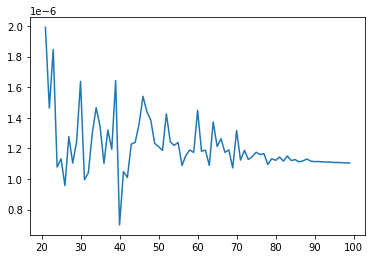

In [3]:
logging.info("Load data...")
seq_mut = pd.read_csv(TRAINING_DATA_FILE)

use_cuda = torch.cuda.is_available()
# use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")

n_factors = 10

batch_size = 128
shuffle = True
learning_rate = 1e-3
weight_decay = 1e-5
n_epochs = 100

training_data = MutationDataset(seq_mut)
training_iter = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=shuffle
)

model = Fixynergy(
    n_seqs=len(training_data.seq_ids),
    n_muts=len(training_data.mut_ids),
    n_factors=n_factors
)
model.to(device)
loss_fn = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

logging.info("Start training")

losses = []
model.train()
for epoch in range(n_epochs):
    for X, y in training_iter:
        X: torch.Tensor = X.to(device)
        y: torch.Tensor = y.to(device)
        pred: torch.Tensor = model(X)

        y = y.float().view(pred.size())
        loss: torch.Tensor = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    logging.info(f"{epoch + 1}/{n_epochs}, loss: {loss.item()}")
    losses.append({
        "epoch": epoch,
        "loss": loss.item()
    })

losses = pd.DataFrame.from_records(losses, index="epoch")
losses = losses[losses.index > n_epochs * 0.2]
plt.plot(losses["loss"])
plt.savefig(TRAINING_LOSSES_PLOT)
logging.info(f"{TRAINING_LOSSES_PLOT} saved!")


In [5]:
logging.info("Mutation score matrix")
model.eval()
with torch.no_grad():
    n_muts = len(training_data.mut_id2name)
    n_seqs = len(training_data.seq_id2name)
    mutation_scores = np.zeros((n_seqs, n_muts))
    for seq_id in training_data.seq_id2name.index:
        X = np.column_stack((
            np.full(n_muts, seq_id),
            training_data.mut_id2name.index
        ))
        X = torch.Tensor(X).int().to(device)
        pred: torch.Tensor = model(X)
        (pred, ) = pred.data.cpu().numpy().T
        mutation_scores[seq_id, :] = pred

mutation_scores = pd.DataFrame(
    mutation_scores,
    index=training_data.seq_id2name.values,
    columns=training_data.mut_id2name.values
)

mutation_scores.to_csv(MUTATION_SCORES_FILE)
logging.info(f"{MUTATION_SCORES_FILE} saved!")


mut_embbedings = model.mut_embedding.weight.data.cpu().numpy()
mut_embbedings = pd.DataFrame(
    mut_embbedings,
    columns=[f"comb_{n}" for n in range(model.n_factors)],
    index=training_data.mut_id2name
)
mut_embbedings.to_csv(EMBEDDINGS_MUT_FILE)
logging.info(f"{EMBEDDINGS_MUT_FILE} saved!")

seq_embbedings = model.seq_embedding.weight.data.cpu().numpy()
seq_embbedings = pd.DataFrame(
    seq_embbedings,
    columns=[f"comb_{n}" for n in range(model.n_factors)],
    index=training_data.seq_id2name
)
seq_embbedings.to_csv(EMBEDDINGS_SEQ_FILE)
logging.info(f"{EMBEDDINGS_SEQ_FILE} saved!")

mutation_scores_2 = seq_embbedings.dot(mut_embbedings.T)
mutation_scores_2.to_csv(MUTATION_SCORES_2_FILE)
logging.info(f"{MUTATION_SCORES_2_FILE} saved!")


[2022-01-09 12:23:32 AM]: Mutation score matrix
[2022-01-09 12:24:20 AM]: Output/mutation_scores.csv saved!
[2022-01-09 12:24:20 AM]: Output/embeddings_mut.csv saved!
[2022-01-09 12:24:20 AM]: Output/embeddings_seq.csv saved!
[2022-01-09 12:24:57 AM]: Output/mutation_scores_2.csv saved!
